In [3]:
!unzip /content/drive/MyDrive/data/archive.zip

Streaming output truncated to the last 5000 lines.
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/273a7a9e-18be-4b6a-976a-fa5ffd69b731___RS_HL 4366_90deg.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/275f8963-f4f4-4903-962b-1da716725d08___RS_HL 4780_90deg.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/275f8963-f4f4-4903-962b-1da716725d08___RS_HL 4780_new30degFlipLR.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/27c2aaa4-de4b-4fb1-ba8d-14d4b24b2afa___RS_HL 4665.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/27c2aaa4-de4b-4fb1-ba8d-14d4b24b2afa___RS_HL 4665_270deg.JPG  
  inflating: new plant diseases dataset(augmented)/New 

In [4]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
import seaborn as sns

In [5]:
# Load datasets
training_set = tf.keras.utils.image_dataset_from_directory(
    '/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train',
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=64,
    image_size=(128, 128),
    shuffle=True
)

validation_set = tf.keras.utils.image_dataset_from_directory(
    '/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid',
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=64,
    image_size=(128, 128),
    shuffle=True
)

Found 70295 files belonging to 38 classes.
Found 17572 files belonging to 38 classes.


In [6]:
# Normalize the pixel values to [0, 1]
normalization_layer = tf.keras.layers.Rescaling(1./255)
training_set = training_set.map(lambda x, y: (normalization_layer(x), y))
validation_set = validation_set.map(lambda x, y: (normalization_layer(x), y))


In [7]:
# Define the RBM class
class RBM(tf.keras.layers.Layer):
    def __init__(self, n_visible, n_hidden):
        super(RBM, self).__init__()
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.W = self.add_weight(shape=(self.n_visible, self.n_hidden), initializer='random_normal', trainable=True)
        self.h_bias = self.add_weight(shape=(self.n_hidden,), initializer='zeros', trainable=True)
        self.v_bias = self.add_weight(shape=(self.n_visible,), initializer='zeros', trainable=True)

    def call(self, v):
        h_prob = tf.nn.sigmoid(tf.matmul(v, self.W) + self.h_bias)
        h_sample = tf.nn.relu(tf.sign(h_prob - tf.random.uniform(tf.shape(h_prob))))
        v_prob = tf.nn.sigmoid(tf.matmul(h_sample, tf.transpose(self.W)) + self.v_bias)
        return v_prob, h_prob

    def reconstruction_error(self, v):
        v_sample, _ = self.call(v)
        return tf.reduce_mean(tf.square(v - v_sample))

# Pretrain RBMs with Early Stopping
def pretrain_rbm(rbm, dataset, epochs=20, batch_size=64, patience=3, min_delta=1e-4):
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    early_stopping = EarlyStopping(monitor='loss', patience=patience, min_delta=min_delta, restore_best_weights=True)

    loss_history = []

    for epoch in range(epochs):
        epoch_loss = 0
        for batch in dataset:
            batch = tf.reshape(batch[0], [batch[0].shape[0], -1])  # Reshape the input
            with tf.GradientTape() as tape:
                loss = rbm.reconstruction_error(batch)
            gradients = tape.gradient(loss, rbm.trainable_variables)
            optimizer.apply_gradients(zip(gradients, rbm.trainable_variables))
            epoch_loss += loss.numpy()

        avg_loss = epoch_loss / len(dataset)
        loss_history.append(avg_loss)
        print(f'Epoch {epoch + 1}, Loss: {avg_loss}')

        # Early stopping condition
        if early_stopping.stopped_epoch > 0 or avg_loss <= min_delta:
            print(f"Early stopping at epoch {epoch + 1}")
            break

    return loss_history


In [8]:
# Create and pretrain RBMs
rbm1 = RBM(128 * 128 * 3, 512)
loss_history_rbm1 = pretrain_rbm(rbm1, training_set, epochs=20)

# Map the hidden representation for the next RBM
hidden_representation = training_set.map(lambda x, y: (rbm1(tf.reshape(x, [-1, 128 * 128 * 3]))[1], y))

# Pretrain rbm2 using the hidden representation from rbm1
rbm2 = RBM(512, 256)
loss_history_rbm2 = pretrain_rbm(rbm2, hidden_representation.map(lambda x, y: (x,)), epochs=20)

Epoch 1, Loss: 0.04069341347638426
Epoch 2, Loss: 0.03873678134776333
Epoch 3, Loss: 0.038518881513393936
Epoch 4, Loss: 0.03845834746970384
Epoch 5, Loss: 0.038390379105851365
Epoch 6, Loss: 0.03836311526711796
Epoch 7, Loss: 0.03830219729650118
Epoch 8, Loss: 0.03792191327323254
Epoch 9, Loss: 0.037837400295186084
Epoch 10, Loss: 0.03785966165546833
Epoch 11, Loss: 0.03788770244603432
Epoch 12, Loss: 0.03801420639295324
Epoch 13, Loss: 0.03814829541565181
Epoch 14, Loss: 0.03825121375819409
Epoch 15, Loss: 0.038319474611570335
Epoch 16, Loss: 0.03837224937385597
Epoch 17, Loss: 0.03840934383844765
Epoch 18, Loss: 0.038448870626089246
Epoch 19, Loss: 0.038481023640552364
Epoch 20, Loss: 0.03849313460168403
Epoch 1, Loss: 0.0023365409863645116
Epoch 2, Loss: 6.0165697774785534e-05
Early stopping at epoch 2


In [48]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping


# Define the DBN model
class DBN(tf.keras.Model):
    def __init__(self, rbm_layers, output_dim):
        super(DBN, self).__init__()
        self.rbm_layers = rbm_layers
        self.output_layer = tf.keras.layers.Dense(output_dim, activation='softmax')

    def call(self, inputs):
        x = tf.reshape(inputs, [-1, 128 * 128 * 3])
        for rbm in self.rbm_layers:
            x = rbm(x)[1]
        return self.output_layer(x)


# Instantiate the DBN model

# Create and compile the DBN model
dbn = DBN([rbm1, rbm2], 38)
dbn.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
# Early stopping callback
import numpy as np
num_samples = 100
x_train = np.random.random((num_samples, 128, 128, 3))
y_train = np.random.randint(10, size=(num_samples,))
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# Fit the model
training_history = dbn.fit(
    training_set,
    epochs=40,
    callbacks=[early_stopping]
)




Epoch 1/40
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.1989 - loss: 3.2063
Epoch 2/40
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.5832 - loss: 1.9244
Epoch 3/40
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.6687 - loss: 1.4162
Epoch 4/40
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.7109 - loss: 1.1615
Epoch 5/40
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.7311 - loss: 1.0221
Epoch 6/40
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.7492 - loss: 0.9266
Epoch 7/40
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.7614 - loss: 0.8626
Epoch 8/40
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.7702 - loss: 0.8181
Epoch 9/40
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.7788 - loss: 0.7806
Epoch 10/40
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.7838 - loss: 0.7504
Epoch 11/40
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.7876 - loss: 0.7268
Epoch 12/40
1099/1099 ━━━━━━━

In [49]:
# Check trainable variables of the DBN model
print("\nTrainable variables of the DBN model:")
for var in dbn.trainable_variables:
    print(f"{var.name}: {var.shape}")



Trainable variables of the DBN model:
variable: (49152, 512)
variable_1: (512,)
variable_2: (49152,)
variable_3: (512, 256)
variable_4: (256,)
variable_5: (512,)
kernel: (256, 38)
bias: (38,)


In [50]:
# Check trainable variables of each RBM
print("\nTrainable variables of RBM 1:")
for var in rbm1.trainable_variables:
    print(f"{var.name}: {var.shape}")

print("\nTrainable variables of RBM 2:")
for var in rbm2.trainable_variables:
    print(f"{var.name}: {var.shape}")



Trainable variables of RBM 1:
variable: (49152, 512)
variable_1: (512,)
variable_2: (49152,)

Trainable variables of RBM 2:
variable_3: (512, 256)
variable_4: (256,)
variable_5: (512,)


In [51]:
# Verify if the RBM outputs and DBN connections are correct
# Example to check a batch flow through the RBM layers
for batch in training_set.take(1):
    images, labels = batch
    reshaped_images = tf.reshape(images, [-1, 128 * 128 * 3])  # Reshape for RBM input
    hidden_rep_rbm1 = rbm1(reshaped_images)[1]
    print("\nHidden representation from RBM 1:", hidden_rep_rbm1.shape)
    hidden_rep_rbm2 = rbm2(hidden_rep_rbm1)[1]
    print("Hidden representation from RBM 2:", hidden_rep_rbm2.shape)



Hidden representation from RBM 1: (64, 512)
Hidden representation from RBM 2: (64, 256)


In [52]:
# Train the DBN model with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

training_history = dbn.fit(
    training_set,
    epochs=45,
    validation_data=validation_set,
    callbacks=[early_stopping]
)

Epoch 1/45
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.8573 - loss: 0.4651 - val_accuracy: 0.7171 - val_loss: 0.9649
Epoch 2/45
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.8621 - loss: 0.4507 - val_accuracy: 0.7158 - val_loss: 0.9869
Epoch 3/45
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.8633 - loss: 0.4456 - val_accuracy: 0.7026 - val_loss: 1.0428
Epoch 4/45
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.8647 - loss: 0.4454 - val_accuracy: 0.7163 - val_loss: 0.9855
Epoch 5/45
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.8637 - loss: 0.4452 - val_accuracy: 0.7075 - val_loss: 1.0099
Epoch 6/45
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.8666 - loss: 0.4370 - val_accuracy: 0.7053 - val_loss: 1.0285


In [53]:
# Evaluate training and validation accuracy
train_loss, train_acc = dbn.evaluate(training_set)
print('Training accuracy:', train_acc)
val_loss, val_acc = dbn.evaluate(validation_set)
print('Validation accuracy:', val_acc)

1099/1099 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.8574 - loss: 0.4668
Training accuracy: 0.8566185235977173
275/275 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7170 - loss: 0.9669
Validation accuracy: 0.7171067595481873


In [56]:
# Load test set
test_set = tf.keras.utils.image_dataset_from_directory(
    '/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid',
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=1,
    image_size=(128, 128),
    shuffle=False
)

Found 17572 files belonging to 38 classes.


In [57]:
# Predict on test set
y_pred = dbn.predict(test_set)
predicted_categories = tf.argmax(y_pred, axis=1)

17572/17572 ━━━━━━━━━━━━━━━━━━━━ 24s 1ms/step


In [58]:
cm = confusion_matrix(Y_true, predicted_categories)

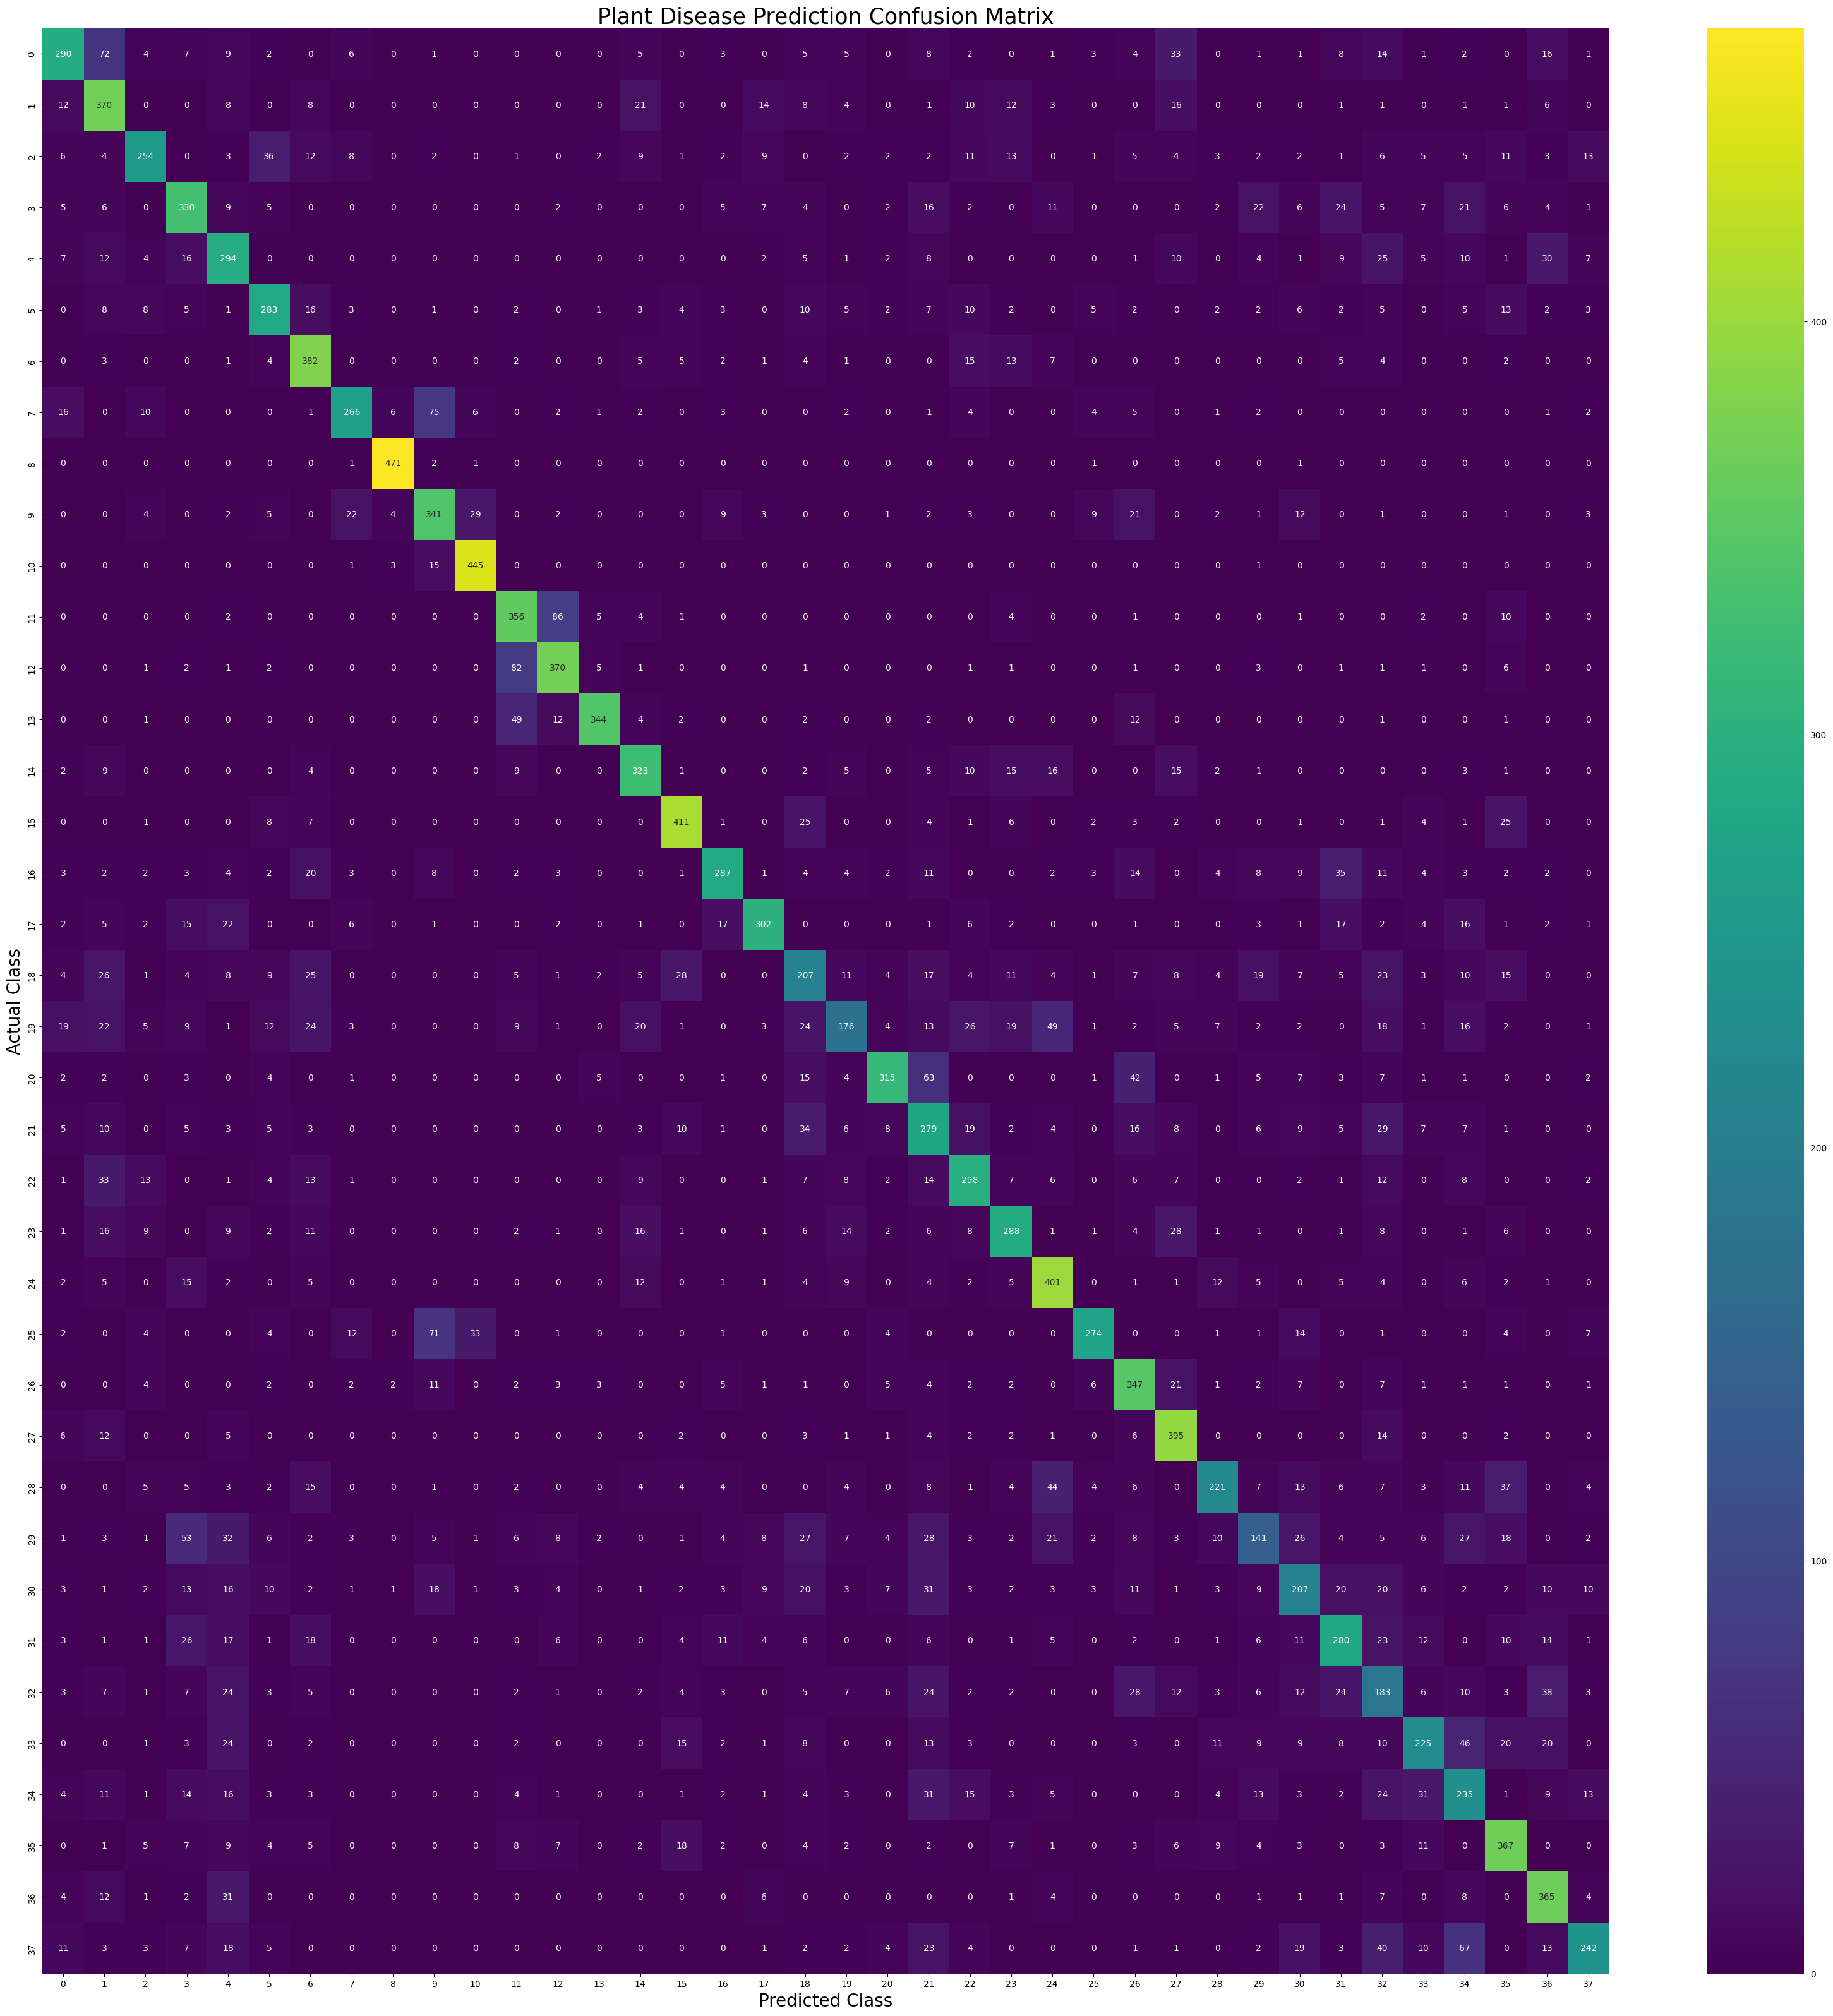

In [59]:
plt.figure(figsize=(40, 40))
sns.heatmap(cm, annot=True, annot_kws={"size": 10}, fmt='g', cmap='viridis')
plt.xlabel('Predicted Class', fontsize=20)
plt.ylabel('Actual Class', fontsize=20)
plt.title('Plant Disease Prediction Confusion Matrix', fontsize=25)
plt.show()

<ipython-input-62-8ec3e8fc0dd9>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Precision', y='Class', data=metrics_df, palette='viridis')


Text(0.5, 1.0, 'Precision per Class')

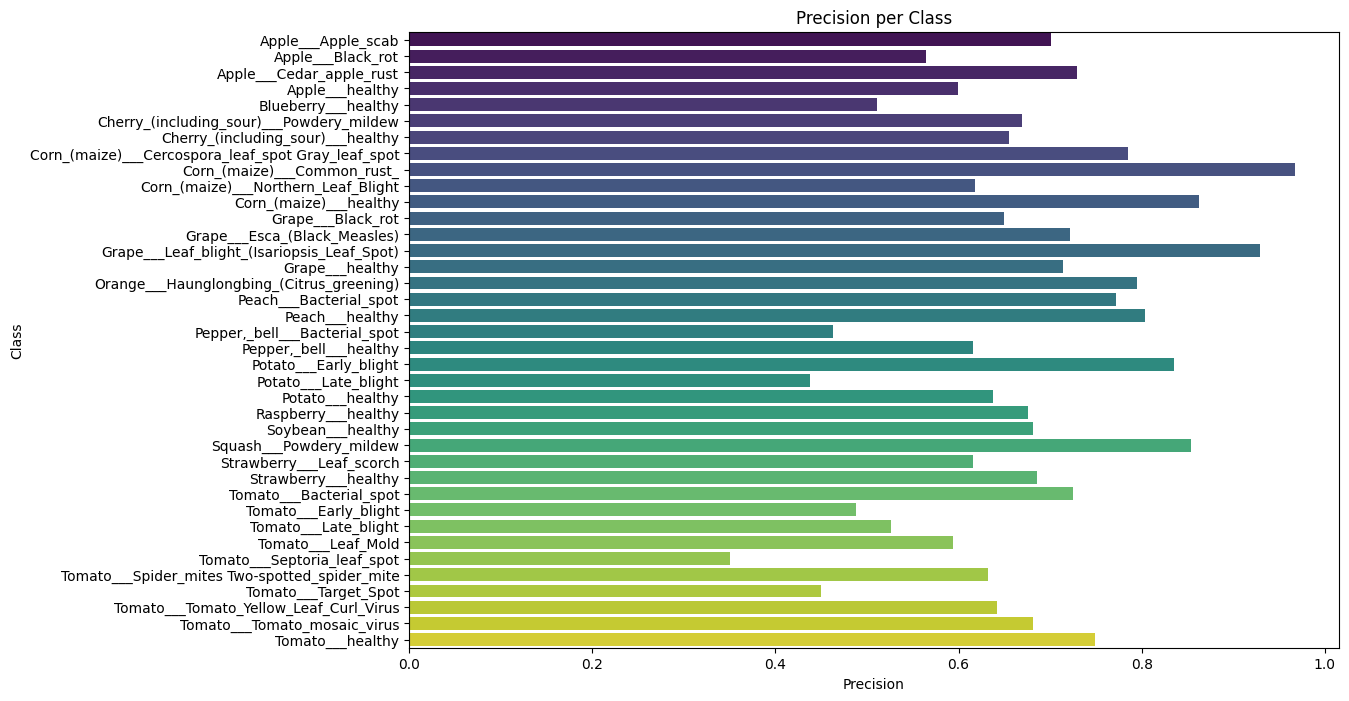

In [62]:
# Precision, Recall, F1-score
from sklearn.metrics import precision_recall_fscore_support
precision, recall, f1_score, _ = precision_recall_fscore_support(Y_true, predicted_categories, average=None)
import pandas as pd
metrics_df = pd.DataFrame({
    'Class': test_set.class_names,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1_score
})

plt.figure(figsize=(12, 8))
sns.barplot(x='Precision', y='Class', data=metrics_df, palette='viridis')
plt.title('Precision per Class')

In [63]:
# Evaluate the DBN model on validation set and generate metrics
val_predictions = dbn.predict(validation_set)
val_labels = np.concatenate([y.numpy() for _, y in validation_set], axis=0)
val_predictions_classes = np.argmax(val_predictions, axis=1)
val_labels_classes = np.argmax(val_labels, axis=1)


275/275 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


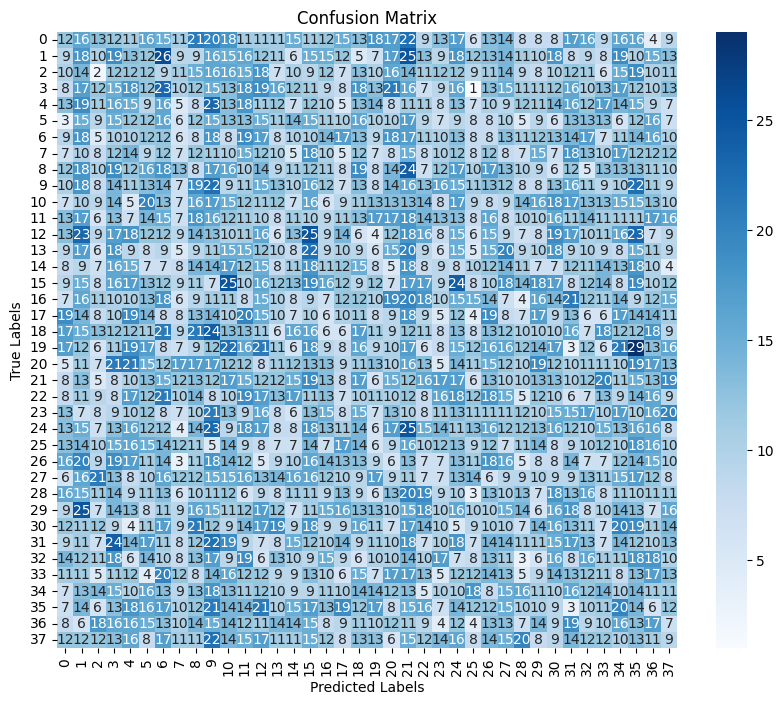

In [64]:
# Confusion Matrix
cm = confusion_matrix(val_labels_classes, val_predictions_classes)
class_names = [str(i) for i in range(38)]  # Assuming 38 classes
plot_confusion_matrix(cm, class_names)


In [65]:
# Classification Report
report = classification_report(val_labels_classes, val_predictions_classes, target_names=class_names, output_dict=True)
print("Classification Report:\n", classification_report(val_labels_classes, val_predictions_classes, target_names=class_names))

Classification Report:
               precision    recall  f1-score   support

           0       0.03      0.02      0.03       504
           1       0.03      0.04      0.03       497
           2       0.01      0.00      0.01       440
           3       0.03      0.03      0.03       502
           4       0.03      0.03      0.03       454
           5       0.03      0.03      0.03       421
           6       0.02      0.03      0.02       456
           7       0.02      0.02      0.02       410
           8       0.02      0.02      0.02       477
           9       0.04      0.05      0.04       477
          10       0.03      0.03      0.03       465
          11       0.02      0.02      0.02       472
          12       0.03      0.03      0.03       480
          13       0.03      0.02      0.02       430
          14       0.03      0.03      0.03       423
          15       0.04      0.04      0.04       503
          16       0.02      0.02      0.02       459
   

In [66]:
# Precision, Recall, and F1-Score per Class
precision = precision_score(val_labels_classes, val_predictions_classes, average=None)
recall = recall_score(val_labels_classes, val_predictions_classes, average=None)
f1 = f1_score(val_labels_classes, val_predictions_classes, average=None)
print("\nPrecision per Class:")
for i, p in enumerate(precision):
    print(f"Class {i}: {p:.4f}")

print("\nRecall per Class:")
for i, r in enumerate(recall):
    print(f"Class {i}: {r:.4f}")

print("\nF1-Score per Class:")
for i, f in enumerate(f1):
    print(f"Class {i}: {f:.4f}")


TypeError: 'numpy.ndarray' object is not callable